In [1]:
import sys
import os
workPath = os.path.abspath('..')
if not workPath in sys.path:
    sys.path.append(workPath)

In [18]:
from timeit import timeit
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from everest import window
from everest import _specialnames
Fetch = window.Fetch
Reader = window.Reader

In [4]:
projName = 'arrbench16'
outputPath = os.path.join(*['..', 'out', 'analysis', projName])
filePath = os.path.join(outputPath, projName + '.h5')

In [5]:
myreader = Reader(filePath)

0.0


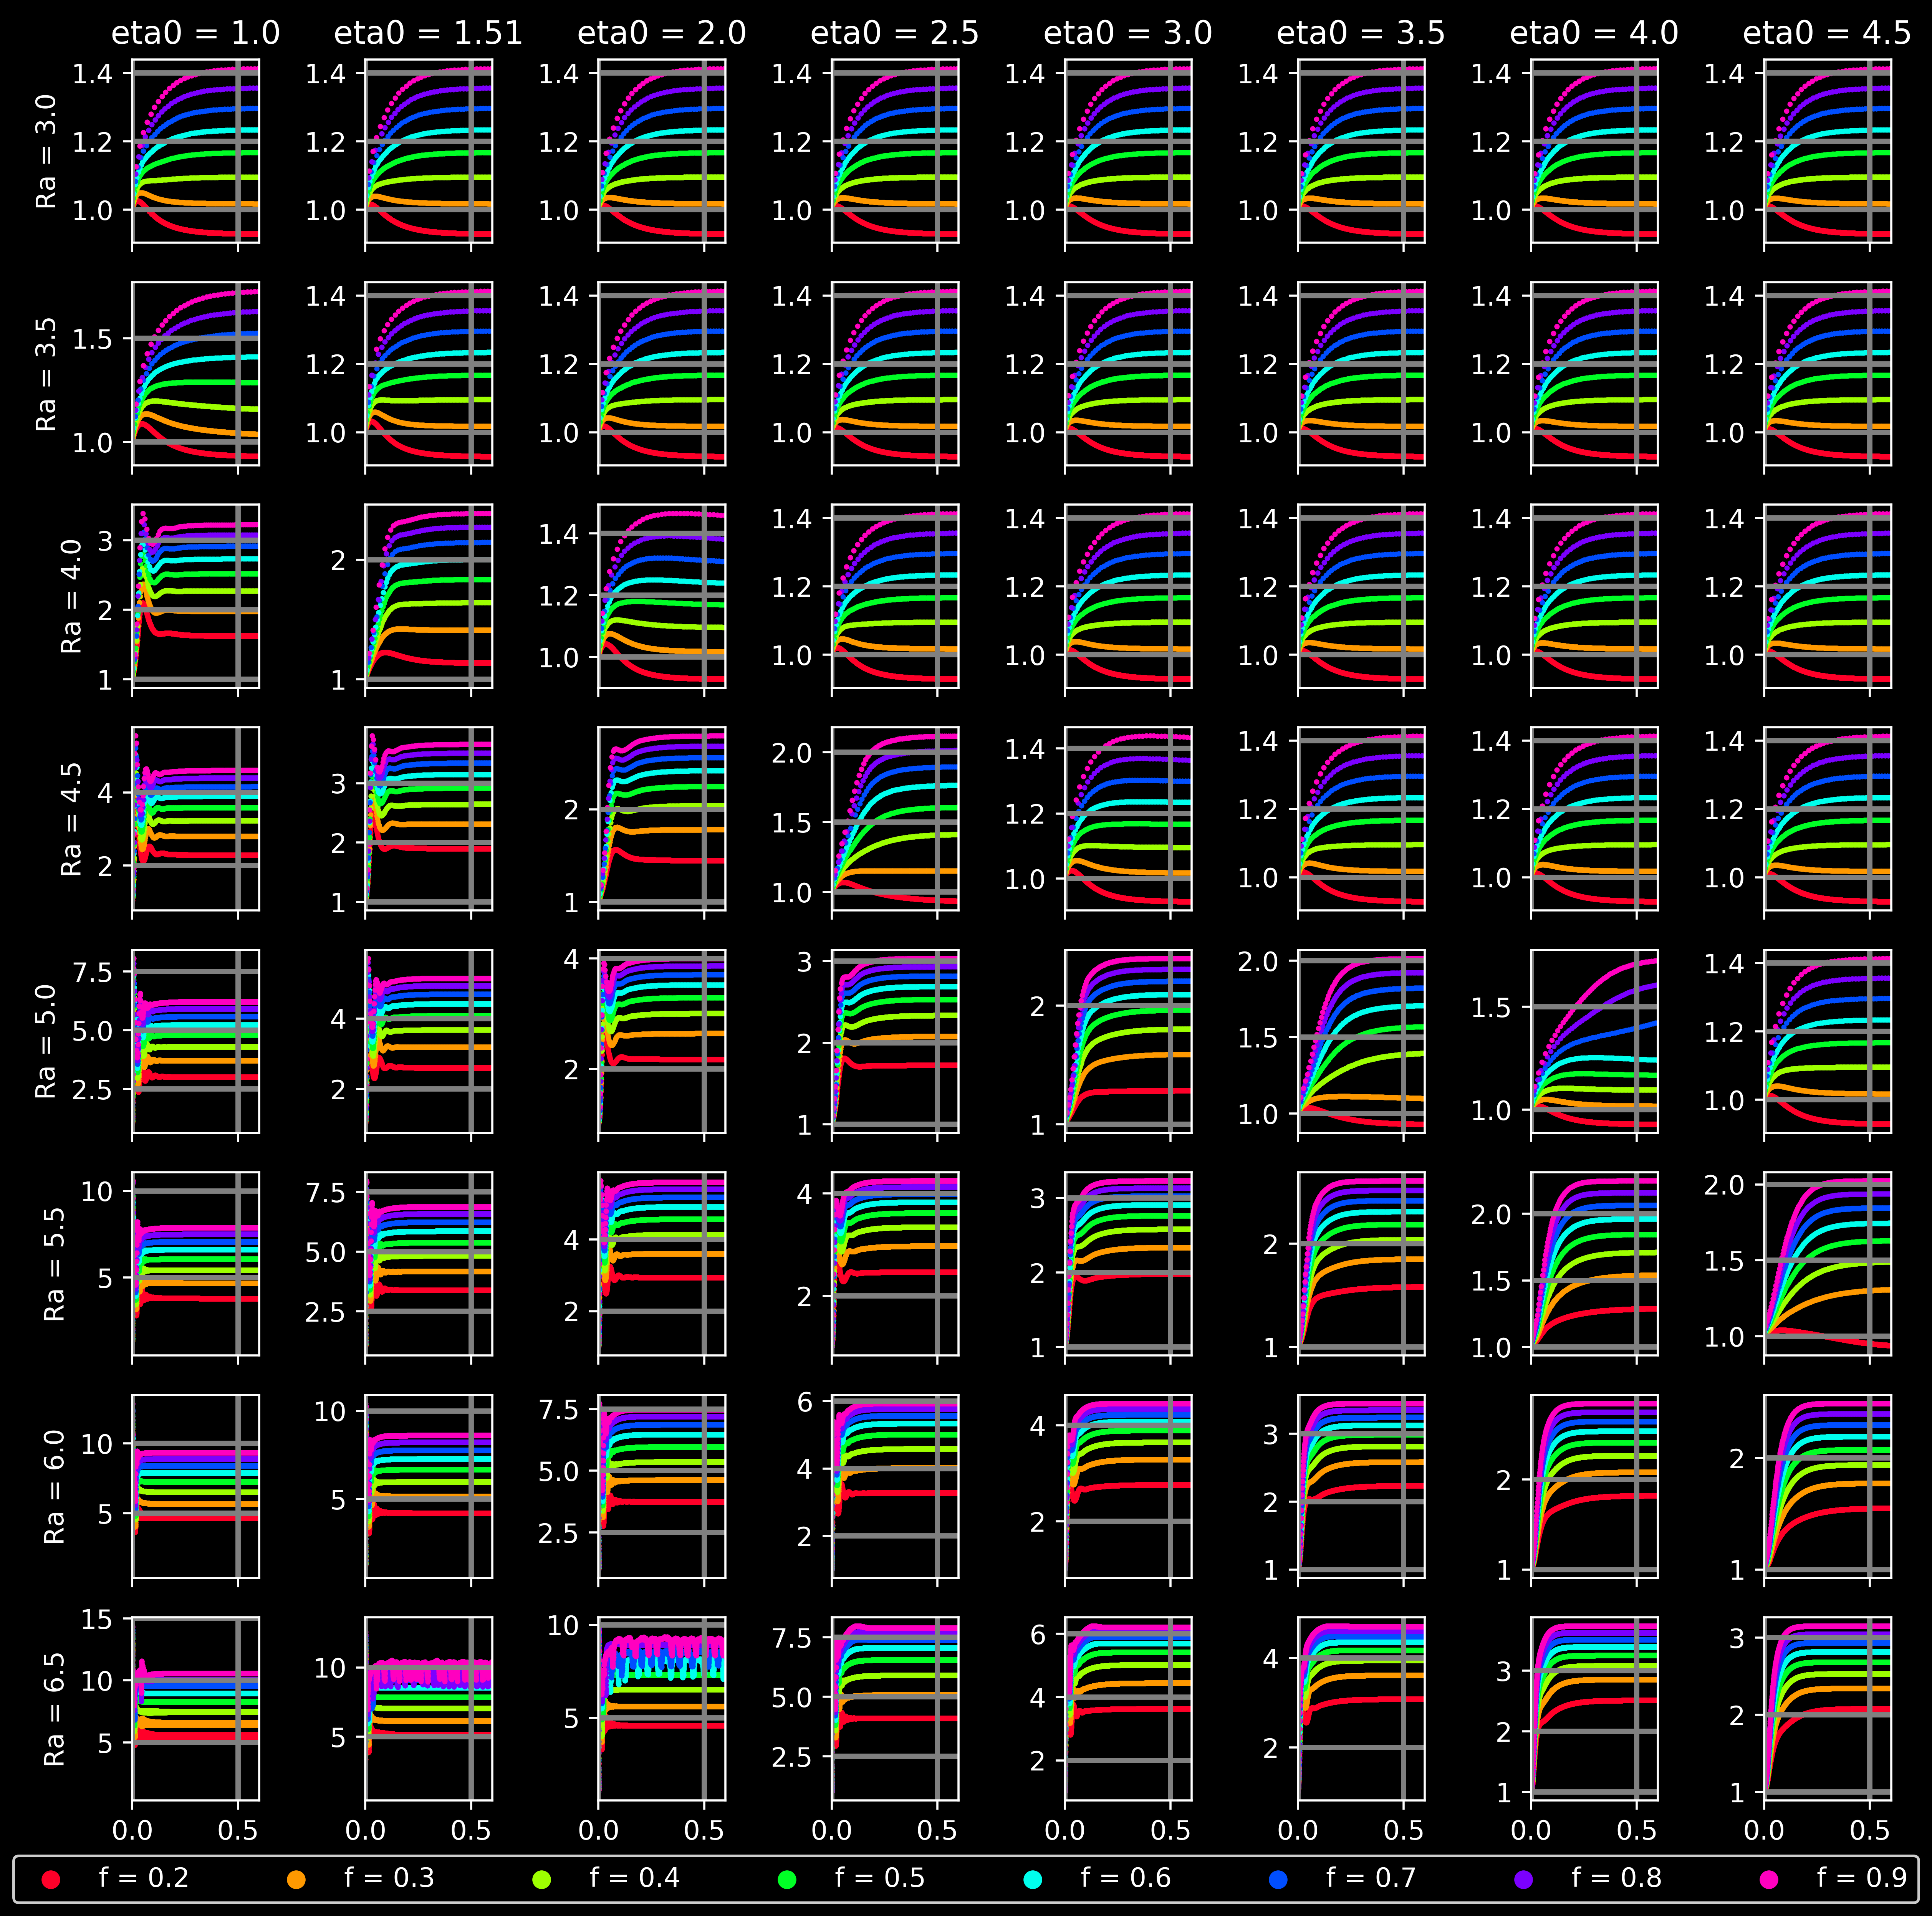

In [48]:
# mpl.rcParams.update({
#     'text.color': "white",
#     'axes.labelcolor': "white"
#     })

# filterScope = myreader[Fetch('Nu') > 0.]
# attrDict = myreader.view_attrs(filterScope)

# fs = sorted(attrDict['f'].keys())[1:-1]
# Ras = sorted(attrDict['Ra'].keys())[:8]
# etas = sorted(attrDict['eta0'].keys())[:8]

# widthInches = 10
# heightInches = 10
# fig, axs = plt.subplots(len(Ras), len(etas), sharex = True, figsize = (widthInches, heightInches), dpi = 500)

# for rowNo, Ra in enumerate(Ras):
#     val = round(math.log(Ra, 10), 2)
#     axs[rowNo][0].set_ylabel('Ra = ' + str(val))
# for colNo, eta0 in enumerate(etas):
#     val = round(math.log(eta0, 10), 2)
#     axs[0][colNo].set_title('eta0 = ' + str(val))

# cmap = plt.get_cmap('gist_rainbow')
# norm = mpl.colors.Normalize(vmin = min(fs), vmax = max(fs))

# for f in fs:
#     for rowNo, Ra in enumerate(Ras):
#         for colNo, eta0 in enumerate(etas):
#             ax = axs[rowNo][colNo]
#             ax.grid(color = 'grey', linestyle = '-', linewidth = 2)
#             ax.tick_params(color = 'white', labelcolor = 'white')
#             ax.set_facecolor('black')
#             for spine in ax.spines.values():
#                 spine.set_edgecolor('white')
#             # ready data
#             thisScope = attrDict['Ra'][Ra] * attrDict['f'][f] * attrDict['eta0'][eta0]
#             if len(thisScope) > 0:
#                 xs = myreader.pull(thisScope, 'modeltime')
#                 ys = myreader.pull(thisScope, 'Nu')
#                 cs = cmap(norm(f))
#                 ss = 1
#                 # plot data
#                 ax.scatter(xs, ys, ss, color = cs)
#                 # some more tweaks
#                 ax.set_xlim((0, 0.6))
# #                 ax.set_ylim((0.9, np.max(ys)))

# axs[int(len(Ras)) - 1][int(len(etas) / 2)].set_xlabel('IGNOREME') # so dumb!
# legendtext = ['f = ' + str(round(val, 2)) for val in fs]
# legend = plt.figlegend(
#     legendtext,
#     facecolor = 'black',
#     loc = 'lower center',
#     shadow = True,
#     mode = 'expand',
#     ncol = len(fs),
#     markerscale = 6.
#     )

# fig.subplots_adjust(hspace = 0)
# fig.set_facecolor('black')
# # fig.suptitle('Isoviscous suite: resolution = ' + str(res))
# fig.tight_layout()
# fig.show()

In [ ]:
# fig = plt.figure(facecolor = 'black', edgecolor = 'black') #figsize = (10, 6), dpi = 1000)
# fig.add_axes()
# ax = fig.add_subplot()
# ax.scatter(xs, ys, c = cs, cmap = 'viridis', s = 100, edgecolor = 'white')
# ax.set_xlabel('log(Ra * f^2)')
# ax.set_ylabel('log(Nu)')
# ax.set_xlim((0, 16))
# ax.set_ylim((0, 3))
# zs = np.polyfit(xs, ys, 1)
# p = np.poly1d(zs)
# plt.plot(xs,p(xs),"r--")
# plt.title("y = %.6fx + %.6f\nscore = 0.98927"%(zs[0],zs[1])) 